In [2]:
import numpy as np
import xarray as xr
import salishsea_tools.river_202108 as rivers
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime

In [2]:
def wrangle_df(river_dataframe, month, month_num, month_days):
    test = river_dataframe[['YEAR','DD', month]]
    mapping = {test.columns[0]: 'YYYY', test.columns[2]: 'DISCHARGE'}
    test2 = test.rename(columns=mapping)
    test2['MM'] = month_num
    test2 = test2.drop(test2[test2['DD'] > month_days].index)
    return test2

In [3]:
def add_dt(df):
    listy = [str(int(year)) for year in df['YYYY']]
    listm = [str.zfill(str(int(month)),2) for month in df['MM']]
    listd = [str.zfill(str(int(day)),2) for day in df['DD']]

    lst = list([listy, listm, listd])

    listdt = list(map('-'.join, zip(*lst)))

    date_format = '%Y-%m-%d'
    listdt_obj = [datetime.strptime(dt_str, date_format) for dt_str in listdt]

    return listdt_obj

In [4]:
def transform_df(df):
    January = wrangle_df(df, 'Jan', 1, 31)
    February = wrangle_df(df, 'Feb', 2, 28)
    March = wrangle_df(df, 'Mar', 3, 31)
    April = wrangle_df(df, 'Apr', 4, 30)
    May = wrangle_df(df, 'May', 5, 31)
    June = wrangle_df(df, 'Jun', 6, 30)
    July = wrangle_df(df, 'Jul', 7, 31)
    August = wrangle_df(df, 'Aug', 8, 31)
    September = wrangle_df(df, 'Sep', 9, 30)
    October = wrangle_df(df, 'Oct', 10, 31)
    November = wrangle_df(df, 'Nov', 11, 30)
    December = wrangle_df(df, 'Dec', 12, 31)

    df_new = pd.DataFrame(np.vstack((January.to_numpy(), February.to_numpy(), March.to_numpy(), April.to_numpy(), May.to_numpy(), June.to_numpy(), July.to_numpy(), August.to_numpy(), September.to_numpy(), October.to_numpy(), November.to_numpy(), December.to_numpy())), columns= ['YYYY', 'DD', 'DISCHARGE', 'MM'])
    
    df_new['DateTime'] = add_dt(df_new)

    return df_new

In [170]:
def make_ts_arr(jdepth, data, volume):
    rho = 1026
    volume_dims = np.array([volume.to_numpy(), volume.to_numpy()])[0:1]
    data_np = data[:, 0:jdepth].values
    river_arr = (1/rho) * np.multiply(volume_dims[:, 0:jdepth], data_np)
    river_sum = np.nansum(np.nansum(np.nansum(river_arr, axis=3), axis=2), axis=1)
    return river_sum

In [8]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [9]:
fw_rivers = xr.open_dataset('/ocean/cdonaldson/research_runs/long_dye_tracers/extractions/SalishSeaCast_river_trace_day_avg_Fraser_all_20170101_20181231.nc')
dep_idx = 40

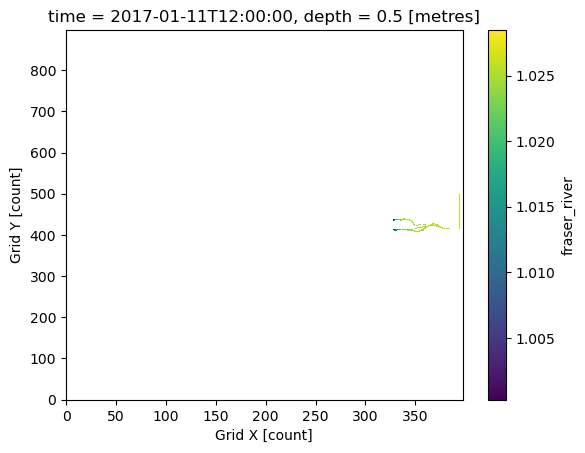

In [39]:
(fw_rivers.fraser_river[10, 0]/1000).where(fw_rivers.fraser_river[10, 0] > 1000).plot()

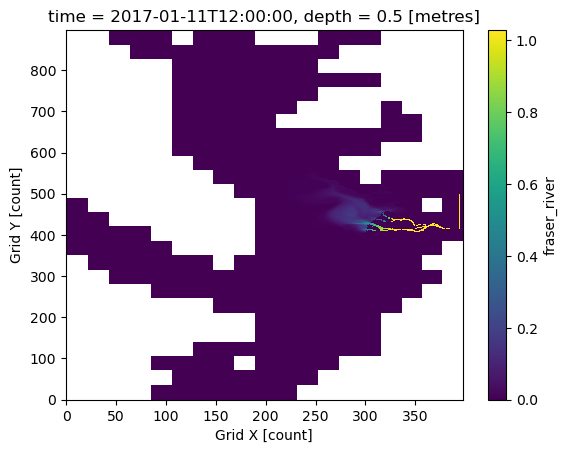

In [40]:
(fw_rivers.fraser_river[10, 0]/1000).plot()

(898, 398)


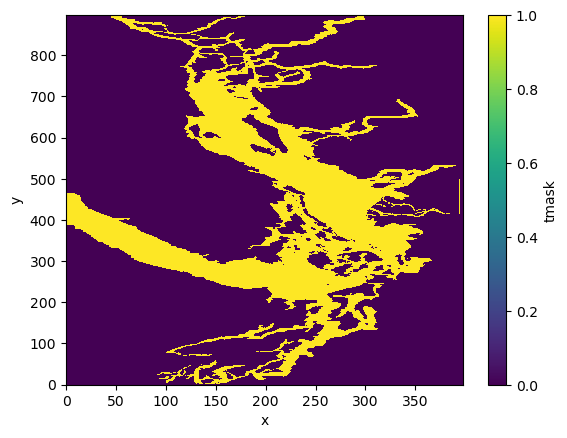

In [153]:
print((1-tmask[0]).shape)
(1-tmask[0]).plot()

(40, 898, 398)


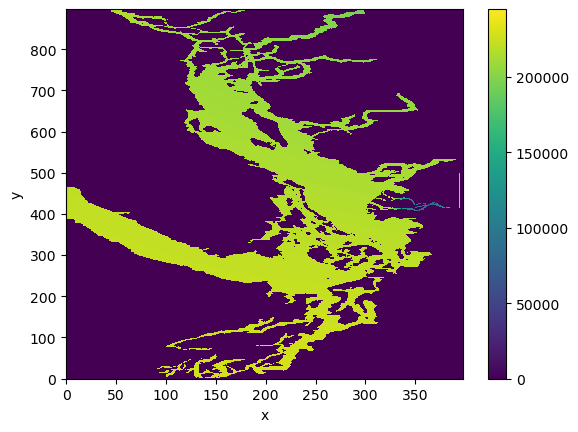

In [154]:
print(volume.shape)
volume[0].plot()

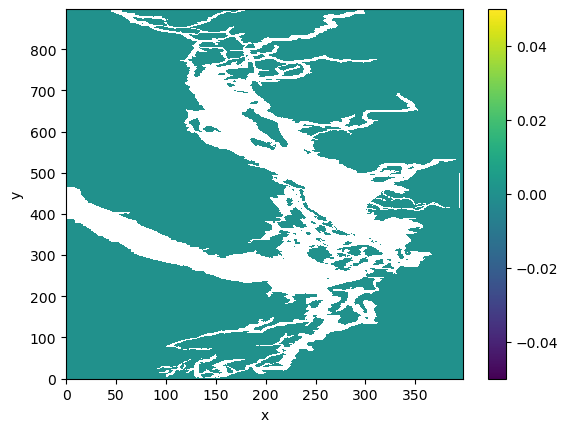

In [155]:
(volume[0]).where(volume[0] == 0).plot()

(1, 40, 898, 398)


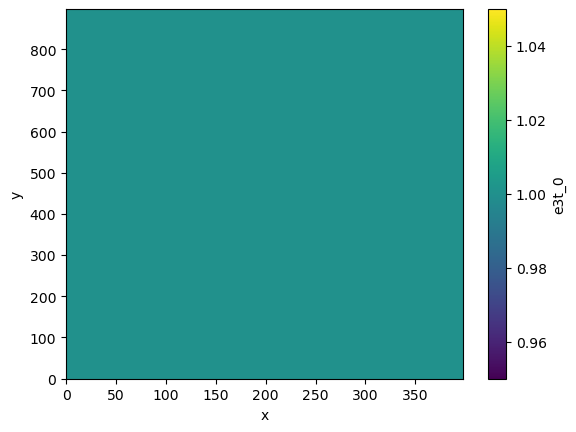

In [156]:
print(mesh.e3t_0.shape)
mesh.e3t_0[0,0].plot()

(1, 898, 398)


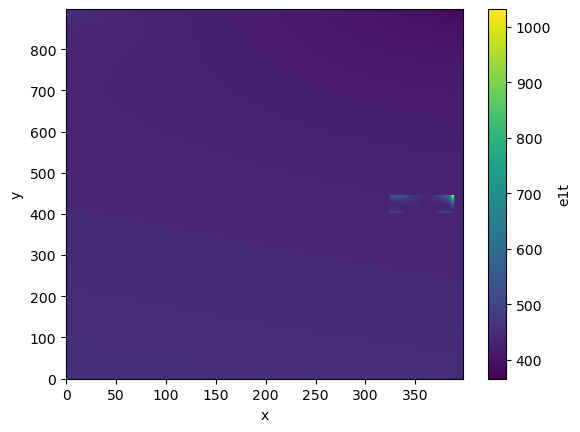

In [157]:
print(mesh.e1t.shape)
mesh.e1t[0].plot()

(1, 898, 398)


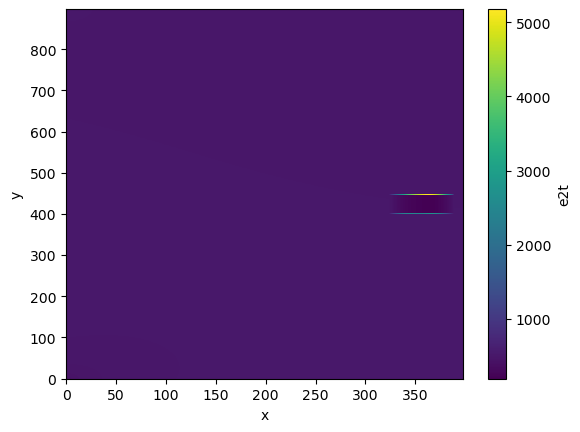

In [158]:
print(mesh.e2t.shape)
mesh.e2t[0].plot()

In [152]:
volume = mesh.e3t_0[0] * mesh.e1t[0] * mesh.e2t[0] * (1-tmask[0])

In [1]:
time = fw_rivers['time'].to_numpy()

Fraser_arr = pd.read_csv('1d_volume_fraser_river_s2017_730_dep_0_40.csv')['0'].to_numpy()

NameError: name 'fw_rivers' is not defined

In [176]:
Fraser_obs = pd.read_csv('/ocean/cdonaldson/MOAD/analysis-cassidy/notebooks/compare_daily_river/Fraser_Hope.csv',header=1)
Fraser_obs = Fraser_obs[Fraser_obs['PARAM'] == 1]
Fraser_obs = transform_df(Fraser_obs).sort_values(by='DateTime')

In [177]:
Fraser_mod = pd.read_csv('river_dailies_to_ts_fraser_20170101_20200101.csv')
Fraser_mod['date'] = pd.to_datetime(Fraser_mod['date'], format='%m-%d-%Y')

In [178]:
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
# the mask is 1 where there is water, we want the opposite.  The meshmask has an extra dimension, hence the [0]
tmask = 1 - mesh.tmask[0]

In [179]:
obs_sel = (Fraser_obs['DateTime'] >= '2017-01-01') & (Fraser_obs['DateTime'] <= '2018-12-31')
Fraser_obs = Fraser_obs[obs_sel]

In [180]:
rho = 1026
runoff_to_m3 = 86400 * (500*440)/rho  #TODO add the seconds back in

In [181]:
# (3000 * 86400 * 365) / 1e9

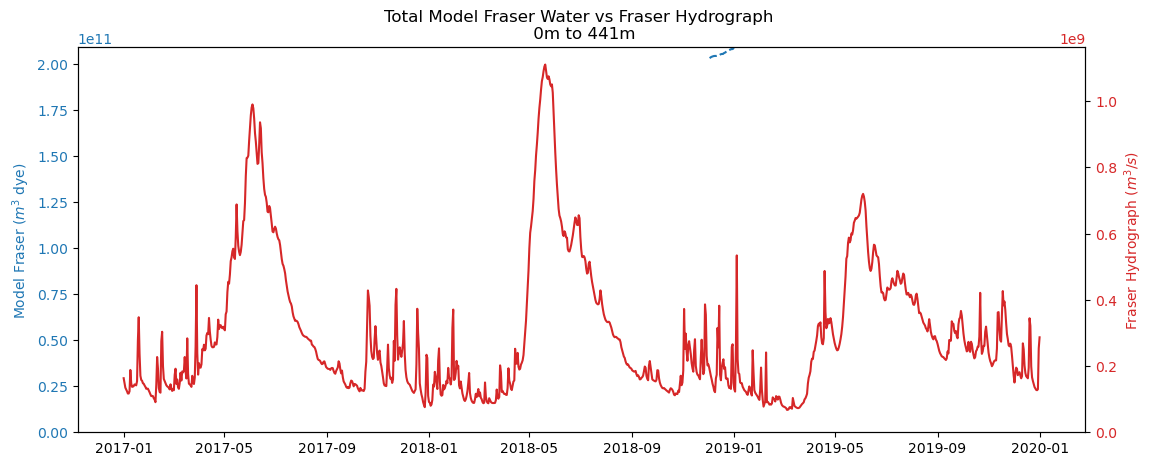

In [186]:
fig, ax1 = plt.subplots(1, 1, figsize=(13, 5))

color1 = 'tab:blue'
ax1.set_title('Total Model Fraser Water vs Fraser Hydrograph \n 0m to {}m'.format( int(float(fw_rivers['depth'][dep_idx-1].values))))
# ax1.plot(time, (1/200)*Fraser_arr, linestyle='--', color=color1)
ax1.plot(time[700:730], Fraser_arr, linestyle='--', color=color1)  # mult by volume
ax1.set_ylabel(r'Model Fraser ($m^3$ dye)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, None)

color2 = 'tab:red'
ax2 = ax1.twinx()
# ax2.plot(Fraser_obs['DateTime'], Fraser_obs['DISCHARGE'], color=color2, linestyle='--')
ax2.plot(Fraser_mod['date'], runoff_to_m3*Fraser_mod['Fraser [kg/m2/s]'], color=color2)
ax2.set_ylabel(r'Fraser Hydrograph ($m^3/s$)', color=color2)
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, None)

plt.savefig('look_at_results/timeseries_plots/Fraser_modelandobs_volume.png')

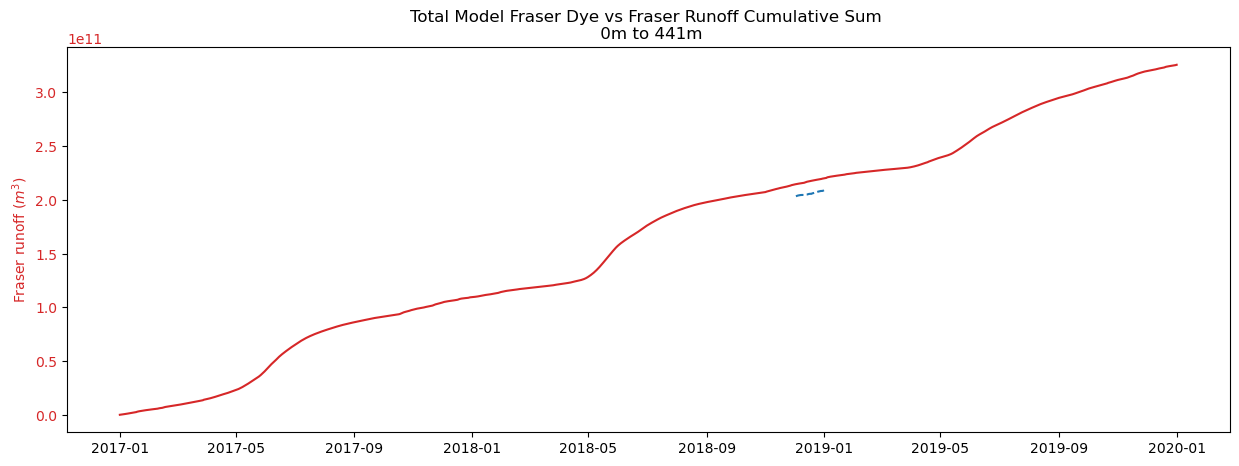

In [188]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

color1 = 'tab:blue'
ax1.set_title('Total Model Fraser Dye vs Fraser Runoff Cumulative Sum \n 0m to {}m'.format( int(float(fw_rivers['depth'][dep_idx-1].values))))
ax1.plot(time[700:730], Fraser_arr, linestyle='--', color=color1)
ax1.set_ylabel(r'Model Fraser ($m^3$ dye/$m^3$ water)', color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
# ax1.set_ylim(0, None)

color2 = 'tab:red'
# ax1.plot(Fraser_mod['date'], runoff_to_m3*np.cumsum(Fraser_mod['Fraser [kg/m2/s]']), color=color2)
# ax1.plot(Fraser_mod['date'], np.cumsum(Fraser_mod['Fraser [kg/m2/s]']), color='tab:purple')

# ax2 = ax1.twinx()
ax1.plot(Fraser_mod['date'], np.cumsum(runoff_to_m3*Fraser_mod['Fraser [kg/m2/s]']), color='tab:red')
ax1.set_ylabel(r'Fraser runoff ($m^3$)', color=color2)
ax1.tick_params(axis='y', labelcolor=color2)


plt.savefig('look_at_results/timeseries_plots/Fraser_modelandmodelin_volume.png')

## Exponential fit

In [ ]:
e1t_arr = np.zeros((40, 898, 398)) + 500
e1t_dshape = e1t_arr[np.newaxis, ...]
e2t_arr = np.zeros((40, 898, 398)) + 440
e2t_dshape = e2t_arr[np.newaxis, ...]
e3t_arr = snap_phys['e3t'].to_numpy()[0, :, :, :]
e3t_dshape = e3t_arr[np.newaxis, ...]

mult_factor = e1t_dshape * e2t_dshape * e3t_dshape

In [ ]:
day0 = fw_rivers['time'][0]
day1 = fw_rivers['time'][364]
day2 = fw_rivers['time'][729]

In [ ]:
# vol0 = (fw_rivers['fraser_river'][fw_rivers['time'] == day0] * mult_factor).sum()
# vol1 = (fw_rivers['fraser_river'][fw_rivers['time'] == day1] * mult_factor).sum()
# vol2 = (fw_rivers['fraser_river'][fw_rivers['time'] == day2] * mult_factor).sum()

vol0 = (fw_rivers['fraser_river'][fw_rivers['time'] == day0]).sum()
vol1 = (fw_rivers['fraser_river'][fw_rivers['time'] == day1]).sum()
vol2 = (fw_rivers['fraser_river'][fw_rivers['time'] == day2]).sum()

In [ ]:
days = [day0.values, day1.values, day2.values]
vols = [vol0, vol1, vol2]

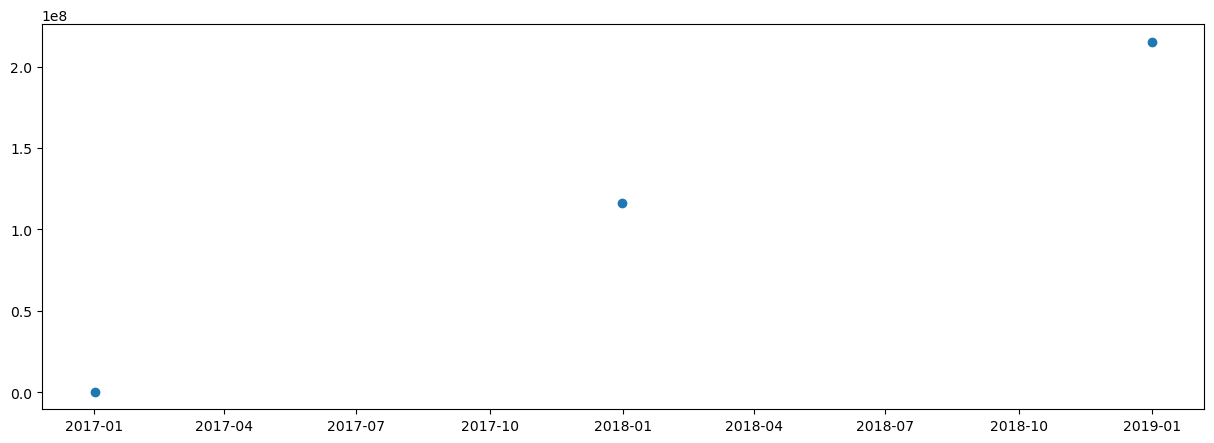

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(15, 5))

color1 = 'tab:blue'
ax1.plot(days, vols, 'o', color=color1)